### Greedy Forest Testing
This code tests the performance of a model that uses greedy forest (pick directions randomly) rather than a probability maximizing forest.

In [1]:
%load_ext autoreload
%autoreload 2

# Inclusions
import socket
import sys, os
if socket.gethostname()=='Andrews-MacBook-Pro.local':
    sys.path.append("/Users/landauland/Documents/GitHub/RatInABox")#os.path.join('C:/', 'Users','andrew','Documents','GitHub','RatInABox'))
else:
    sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))

import time
import numpy as np
import numba as nb
import scipy
from scipy.spatial.distance import squareform, pdist, cdist
import copy
import matplotlib.pyplot as plt
import simulateHippocampalData as simData 
import mind_mindModel1 as mind
import mind_ppca1 as mppca

from tqdm.notebook import tqdm, trange

In [2]:
# Generate and plot some place cells and grid cells
NP = 50 # number of place cells
NG = 50 # number of grid cells
boxLength = 88 # 88cm box length (square arena)
gNoiseAmp = 1/100000 # noise standard deviation relative to signal standard deviation
placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module
baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)

In [3]:
xpos,ypos = simData.getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[simData.randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([simData.getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[simData.randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([simData.getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')
print(f"Min/max of place library is {np.min(placeLibrary):.1f}/{np.max(placeLibrary)}")
print(f"Min/max of grid library is {np.min(gridLibrary):.1f}/{np.max(gridLibrary)}")

Shape of place library is (50, 88, 88)
Shape of grid library is (50, 88, 88)
Min/max of place library is 0.0/1.0
Min/max of grid library is -0.5/1.0


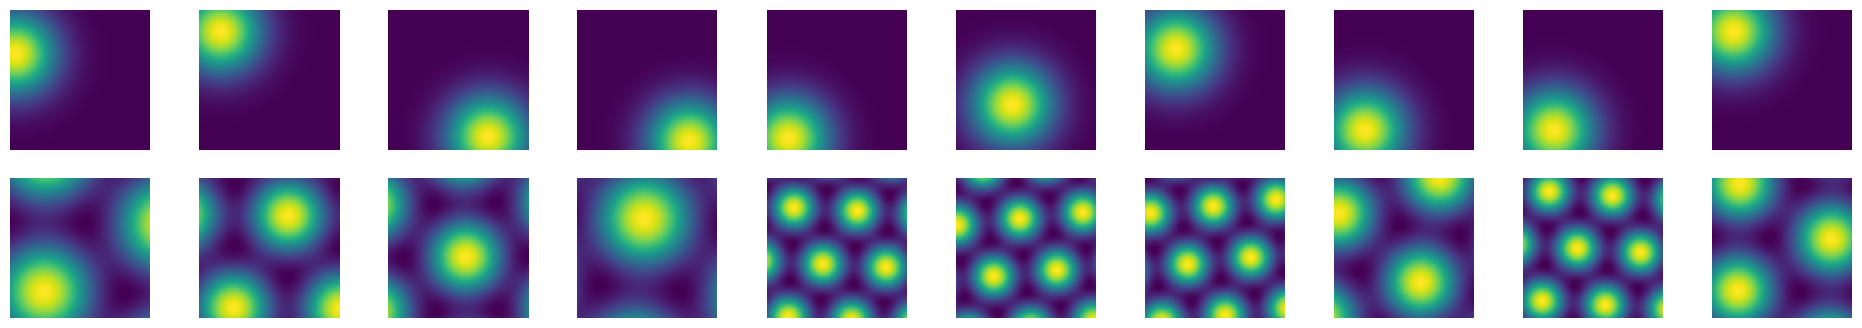

In [4]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [5]:
# Generate a trajectory in the environment
Env = simData.Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = simData.Agent(Env,{"dt":0.1,"speed_mean":0.08})
for i in tqdm(range(100000)): # Use standard number of datapoints, independent of time step
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

In [6]:
# Return place and grid cell activity along trajectory, with noise if requested
placeActivitySignal = placeLibrary[:,posidx[:,0],posidx[:,1]].T
gridActivitySignal = gridLibrary[:,posidx[:,0],posidx[:,1]].T
hippoActivitySignal = np.concatenate((placeActivitySignal,gridActivitySignal),axis=1)

# Add Noise
gNoiseAmp = 1/5
gNoisePlace = gNoiseAmp * np.std(placeActivitySignal,axis=0)
gNoiseHippo = gNoiseAmp * np.std(hippoActivitySignal,axis=0)
placeActivity = placeActivitySignal + np.random.normal(0,gNoisePlace,placeActivitySignal.shape)
hippoActivity = hippoActivitySignal + np.random.normal(0,gNoiseHippo,hippoActivitySignal.shape)

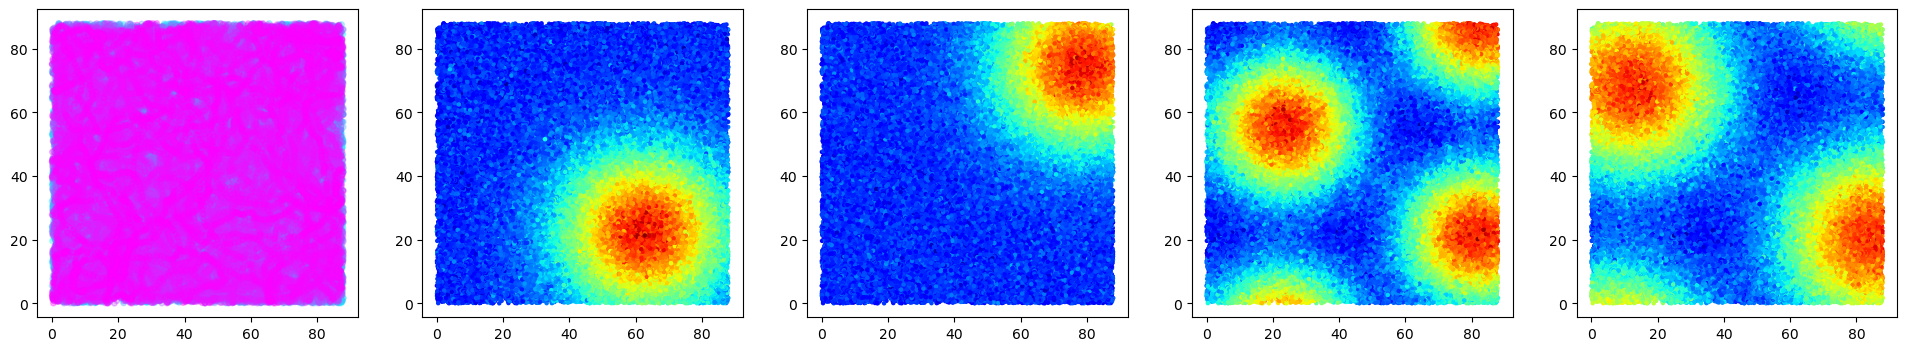

In [7]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
# Ag.plot_trajectory(ax=ax[0])
plt.set_cmap('cool')
ax[0].scatter(pos[:,0],pos[:,1],s=15,c=range(pos.shape[0]),alpha=0.3)
plt.set_cmap('jet')
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=5,c=placeActivity[:,pexidx[n]])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=5,c=hippoActivity[:,NP+gexidx[n]])

In [14]:
# Define activity to make models with for full forest and greedy forest
useType = 'hippo'
xp4,yp4 = simData.getBoxCoord(boxLength,4) # for indexing the mesh
xpv = xp4.reshape(-1)
ypv = yp4.reshape(-1)

# Create activity array (and inlines for getting mesh / centers) 
if useType=='hippo':
    useActivity = copy.copy(hippoActivity)
    useMesh = lambda ppca : (np.concatenate((placeLibrary[:,xpv,ypv].T,gridLibrary[:,xpv,ypv].T),axis=1) - ppca.u) @ ppca.v
    useCenter = lambda ppca,x,y : (np.concatenate((placeLibrary[:,x,y].reshape(1,-1),gridLibrary[:,x,y].reshape(1,-1)),axis=1) - ppca.u) @ ppca.v
else:
    useActivity = copy.copy(placeActivity)
    useMesh = lambda ppca : (placeLibrary[:,xpv,ypv].T - ppca.u) @ ppca.v
    useCenter = lambda ppca,x,y : (placeLibrary[:,x,y].T - ppca.u) @ ppca.v

In [51]:
%%time 
opts = {'numScafPoints':800,'nLeaf':100, 'hpGreedy':False}
numTrees = 20

fullMind = mind.mindModel(opts)
fullMind.addData(useActivity)
fullMind.constructForest(numTrees,simpleUpdates=False)
fullMind.summarizeForest()
fullMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: total: 4min 21s
Wall time: 2min 15s


In [52]:
%%time
opts = {'numScafPoints':800,'nLeaf':100, 'hpGreedy':True}
numTrees = 20

greedyMind = mind.mindModel(opts)
greedyMind.addData(useActivity)
greedyMind.constructForest(numTrees,simpleUpdates=False)
greedyMind.summarizeForest()
greedyMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: total: 1min 39s
Wall time: 1min 37s


In [53]:
%%time
opts = {'numScafPoints':800,'nLeaf':100, 'hpGreedy':True, 'nQuant':1, 'nDir':4}
numTrees = 20

fastMind = mind.mindModel(opts)
fastMind.addData(useActivity)
fastMind.constructForest(numTrees,simpleUpdates=False)
fastMind.summarizeForest()
fastMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: total: 52.9 s
Wall time: 49.7 s


In [54]:
%%time
opts = {'numScafPoints':800,'nLeaf':100, 'hpGreedy':True, 'nQuant':1, 'nDir':2}
numTrees = 20

efficientMind = mind.mindModel(opts)
efficientMind.addData(useActivity)
efficientMind.constructForest(numTrees,simpleUpdates=False)
efficientMind.summarizeForest()
efficientMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: total: 42.7 s
Wall time: 40 s


In [56]:
# Measure the probability of transitions in true data
# Compare whether the greedy model estimates the transitions better...
fullTransProb = fullMind.smartForestLikelihood(fullMind.drData[:-1], fullMind.drData[1:])
greedyTransProb = greedyMind.smartForestLikelihood(greedyMind.drData[:-1], greedyMind.drData[1:])
fastTransProb = fastMind.smartForestLikelihood(fastMind.drData[:-1], fastMind.drData[1:])
effTransProb = efficientMind.smartForestLikelihood(efficientMind.drData[:-1], efficientMind.drData[1:])

Text(0.5, 1.0, 'log-likelihood between real transitions')

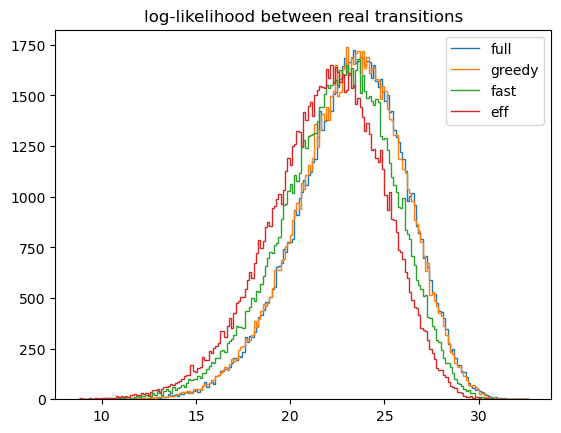

In [57]:
fullCounts,bins = np.histogram(np.log(fullTransProb),bins=200)
greedyCounts = np.histogram(np.log(greedyTransProb),bins=bins)[0]
fastCounts = np.histogram(np.log(fastTransProb),bins=bins)[0]
effCounts = np.histogram(np.log(effTransProb),bins=bins)[0]
plt.stairs(fullCounts, bins, label='full')
plt.stairs(greedyCounts, bins, label='greedy')
plt.stairs(fastCounts, bins, label='fast')
plt.stairs(effCounts, bins, label='eff')
plt.legend()
plt.title('log-likelihood between real transitions')

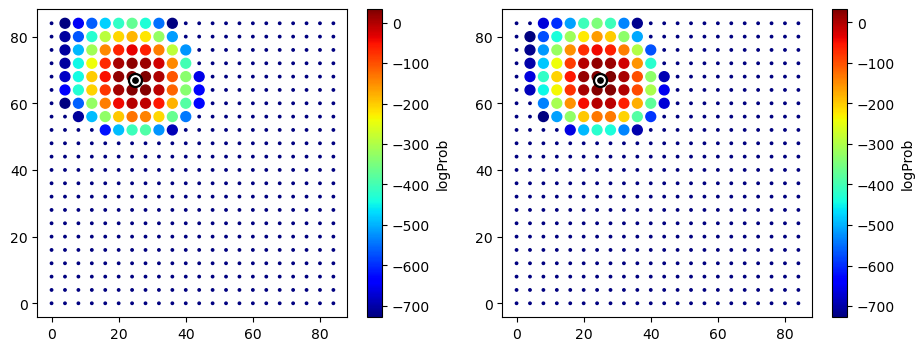

In [19]:
xC,yC = 25,67
fullMeshProb = fullMind.smartForestLikelihood(np.repeat(useCenter(fullMind.drPPCA,xC,yC).reshape(1,-1),useMesh(fullMind.drPPCA).shape[0],axis=0), useMesh(fullMind.drPPCA))
greedyMeshProb = greedyMind.smartForestLikelihood(np.repeat(useCenter(greedyMind.drPPCA,xC,yC).reshape(1,-1),useMesh(greedyMind.drPPCA).shape[0],axis=0), useMesh(greedyMind.drPPCA))

fig,ax = plt.subplots(1,2,figsize=(11,4))

fullNonzero = np.where(fullMeshProb != 0)[0]
fullZero = np.where(fullMeshProb == 0)[0]
cLimits = (np.min(np.log(fullMeshProb[fullNonzero])), np.max(np.log(fullMeshProb[fullNonzero])))
xx = ax[0].scatter(xpv[fullNonzero],ypv[fullNonzero],s=50,c=np.log(fullMeshProb[fullNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xpv[fullZero],ypv[fullZero],s=3,c=cLimits[0]*np.ones_like(xpv[fullZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xC,yC,s=100,c='k')
ax[0].scatter(xC,yC,s=45,c='w')
ax[0].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[0],label='logProb')

greedyNonzero = np.where(greedyMeshProb != 0)[0]
greedyZero = np.where(greedyMeshProb == 0)[0]
cLimits = (np.min(np.log(greedyMeshProb[greedyNonzero])), np.max(np.log(greedyMeshProb[greedyNonzero])))
xx = ax[1].scatter(xpv[greedyNonzero],ypv[greedyNonzero],s=50,c=np.log(greedyMeshProb[greedyNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xpv[greedyZero],ypv[greedyZero],s=3,c=cLimits[0]*np.ones_like(xpv[greedyZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xC,yC,s=100,c='k')
ax[1].scatter(xC,yC,s=45,c='w')
ax[1].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[1],label='logProb')

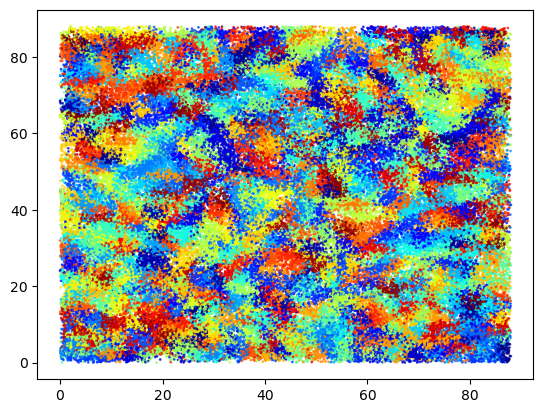

In [21]:
useTreeIdx = 0
pathIndices = fullMind.returnPathIndexLoop(fullMind.drData,useTreeIdx)
numPaths = len(fullMind.treeSummary[useTreeIdx])
randIndexDict = dict(zip(np.arange(numPaths),np.random.permutation(numPaths)))
plt.scatter(pos[:,0],pos[:,1],s=1,c=[randIndexDict[pi] for pi in pathIndices],alpha=0.7)

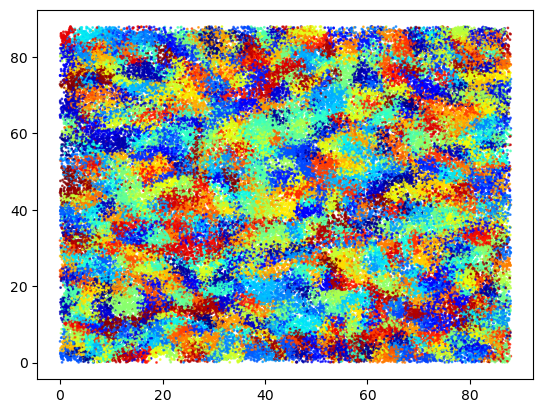

In [22]:
useTreeIdx = 0
pathIndices = greedyMind.returnPathIndexLoop(greedyMind.drData,useTreeIdx)
numPaths = len(greedyMind.treeSummary[useTreeIdx])
randIndexDict = dict(zip(np.arange(numPaths),np.random.permutation(numPaths)))
plt.scatter(pos[:,0],pos[:,1],s=1,c=[randIndexDict[pi] for pi in pathIndices],alpha=0.7)

In [2]:
def fastLikelihood(data, u, iS, logDet, D): 
    udata = data - u
    exparg = np.einsum('dm,dmn,dn->d',udata, iS, udata)
    logLikelihood = -D/2*np.log(2*np.pi) - logDet/2 - exparg/2
    return np.exp(logLikelihood)

@nb.njit(nogil=True, parallel=True)
def fasterLikelihood(data, u, iS, logDet, D):
    udata = data - u
    exparg = np.einsum('dm,dmn,dn->d',udata, iS, udata)
    logLikelihood = -D/2*np.log(2*np.pi) - logDet/2 - exparg/2
    return np.exp(logLikelihood)

In [3]:
D,N = 100,500
data = np.random.normal(0,1,(D,N))
u = np.random.normal(0,1,(D,1))
iS = np.random.normal(0,1,(D,N,N))
logDet = np.random.normal(0,1,D)
%time fastLikelihood(data,u,iS,logDet,D)
%time fasterLikelihood(data,u,iS,logDet,D)

CPU times: total: 31.2 ms
Wall time: 20 ms


C:\Users\andrew\AppData\Local\Temp\ipykernel_19464\2904498645.py:5: RuntimeWarning: overflow encountered in exp
  return np.exp(logLikelihood)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_19464\2904498645.py", line 10:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\andrew\AppData\Local\Temp\ipykernel_19464\2904498645.py (10)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_19464\2904498645.py", line 10:[0m
[1m<source missing, REPL/exec in use?>[0m
